<center><font size = "10"> Week 6 - Single Cell Electrophysiology <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: ELiser Josan Romero
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

In [1]:
# This will compile the mechanisms inside the MOD files (and create a new folder x86_64/special).
! nrnivmodl

/home/biophysics-NX-450/Week_6
Mod files: "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [2]:
# Load usefull packages
%matplotlib inline
from neuron import h
import hoc
import matplotlib.pyplot as plt
import numpy as np
import math as m
import seaborn as sns
import neurom as nm


--No graphics will be displayed.


In [3]:
sns.set_style("darkgrid")

# <font color= 'red'>Ex1:</font> Stimulation protocols to study various cell properties

<font size='3'>
Your task is to design and perform two different stimulation protocols that could be used to study the AP properties (e.g. amplitude, shape, rise-time, fall-time) and passive properties (e.g. input resistance and voltage base). Apply the protocols to the cells you have in your group folder (two .asc files). When defining the cells biophysics, use the passive, active properties and mechanisms (MOD files) used in tutorial 01. Don't include any biophysics on the cell axon, as it was done in Tutorial 01.


<font size='3'>Run the protocols and discuss in your own words, why do you think these types of protocols are useful when studying cell functional characteristics and behavior? <font color= 'red'>[2 pts]
    

### Instantiation of the cells

In [5]:
# Define NEURON class with specific morphology and channel behavior

class NEURON:
    def __init__(self, file):
        self.build_morphology(file)
        self.define_biophysics()
        
    def build_morphology(self,file):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # We have a .swc morphology file
        cell = h.Import3d_Neurolucida3()

        # Read the file and creates automatically section.connect(parent) statements
        cell.input(file)

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.basal = []
        self.apical = []
        #self.axonal = [] # for the moment we will forget about the axon
        self.all = []
        for sec in h.allsec():
            #print (sec)
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.basal.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            #if 'axon' in sec.name():
            #    self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and the different types
        of ion channels on the soma and dendrites
        """
        # Define passive properties
        # You can try to change the passice properties and see what happens
        for sec in h.allsec():
            sec.Ra = 100
            sec.cm = 1
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
                
        # Define active properties for soma and dendrites (basal and apical)
        for sec in self.somatic:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
          
        for sec in self.apical:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
        
        for sec in self.basal:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1

## Defining protocol function

In [4]:
def passive_protocol(Cell, nb, stim_ampl):
    # Inject current steps into the soma
    #stim_ampl = [- 0.05, - 0.01, 0.1]
    
    # Define plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Passive protocole for cell_{nb}")
    #fig1, ax1 = plt.subplots()
    ax1.set(xlabel = 't (ms)', ylabel = 'V (mV)')

    #fig2, ax2 = plt.subplots()
    ax2.set(xlabel = 't (ms)', ylabel = 'I (nA)')
    
    # Stimulation
    for sa in stim_ampl:  
        # Place a stimulation electrode in the middle of the soma
        stim = h.IClamp(Cell.somatic[0](0.5))         
        stim.delay = 100   # stim delay (ms)
        stim.dur = 300     # stim duration (ms)
        stim.amp = sa    # stim amplitude (nA)    
        # Initialize NEURON vectors to record time, voltage and current
        # time vector
        rec_t = h.Vector()
        rec_t.record(h._ref_t)
        # membrame potential vector
        rec_v_soma = h.Vector()
        rec_v_soma.record(Cell.somatic[0](0.5)._ref_v)
        # current
        rec_i = h.Vector()
        rec_i.record(stim._ref_i)

        # Initialize and run a simulation
        h.load_file('stdrun.hoc')
        h.finitialize(-65)
        h.continuerun(500)

        ax1.plot(rec_t, rec_v_soma, label= f"stim at {sa}nA")
        ax1.legend(loc='upper right')
        ax2.plot(rec_t, rec_i, label= f"stim at {sa}nA")
        ax2.legend(loc='upper right')
        
    plt.tight_layout()
    
def active_protocole(Cell, nb, stim_ampl):
    # Inject current steps into the soma
    #stim_ampl = [0.01, 0.5, 1.0]

    # Define plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    fig.suptitle(f"AP protocole for cell_{nb}")
    
    #fig1, ax1 = plt.subplots(figsize=(15,3))
    ax1.set(xlabel = 't (ms)', ylabel = 'V (mV)')

    #fig2, ax2 = plt.subplots(figsize=(15,3))
    ax2.set(xlabel = 't (ms)', ylabel = 'I (nA)')

    # Stimulation
    for sa in stim_ampl:  
        # Place a stimulation electrode in the middle of the soma
        stim = h.IClamp(Cell.somatic[0](0.5))         
        stim.delay = 100   # stim delay (ms)
        stim.dur = 300     # stim duration (ms)
        stim.amp = sa    # stim amplitude (nA)    
        # Initialize NEURON vectors to record time, voltage and current
        # time vector
        rec_t = h.Vector()
        rec_t.record(h._ref_t)
        # membrame potential vector
        rec_v_soma = h.Vector()
        rec_v_soma.record(Cell.somatic[0](0.5)._ref_v)
        # current
        rec_i = h.Vector()
        rec_i.record(stim._ref_i)

        # Initialize and run a simulation
        h.load_file('stdrun.hoc')
        h.finitialize(-65)
        h.continuerun(500)

        ax1.plot(rec_t, rec_v_soma, label= f"stim at {sa}nA")
        ax1.legend(loc='upper right')
        ax2.plot(rec_t, rec_i, label= f"stim at {sa}nA")
        ax2.legend(loc='upper right')
    
    plt.tight_layout()

### First cell

In [6]:
cell_1 = NEURON('group8/Cell1_g6.asc')


5771 lines read

group8/Cell1_g6.asc problems


Main branch starting at line 31 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


In [7]:
# As we didn't define all the cell properties, there are some that have defalut values
# We can check those values and check what other mechanisms are in the soma for instance.

cell_1.somatic[0].psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [3e-05], 'e': [-75.0], 'i': [0.0]},
  'NaTs2_t': {'gNaTs2_tbar': [0.25],
   'ina': [0.0],
   'gNaTs2_t': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'SK_E2': {'gSK_E2bar': [0.01], 'ik': [0.0], 'gSK_E2': [0.0], 'z': [0.0]},
  'SKv3_1': {'gSKv3_1bar': [0.1], 'ik': [0.0], 'gSKv3_1': [0.0], 'm': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]},
  'ca': {'eca': [132.4579341637009],
   'cai': [5e-05],
   'cao': [2.0],
   'ica': [0.0],
   'dica_dv_': [0.0]}},
 'morphology': {'L': 19.971796538082938,
  'diam': [10.172315310917948],
  'pts3d': [(-1.0539026260375977, -10.203926086425781, 0.0, 4.143356800079346),
   (-1.011206865310669, -9.206249237060547, 0.0, 7.248715877532959),
   (-0.9685111045837402, -8.208572387695312, 0.0, 9.444008827209473),
   (-0.9258153438568115, -7.210896015

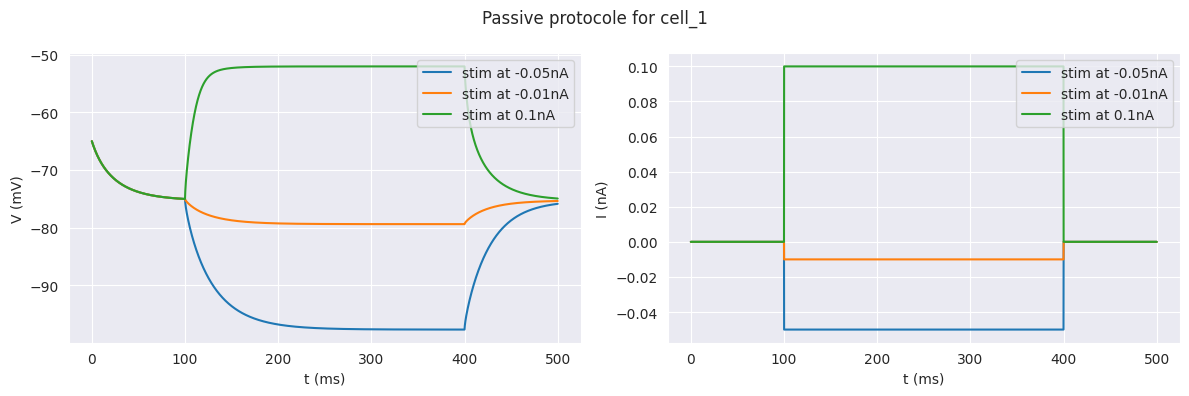

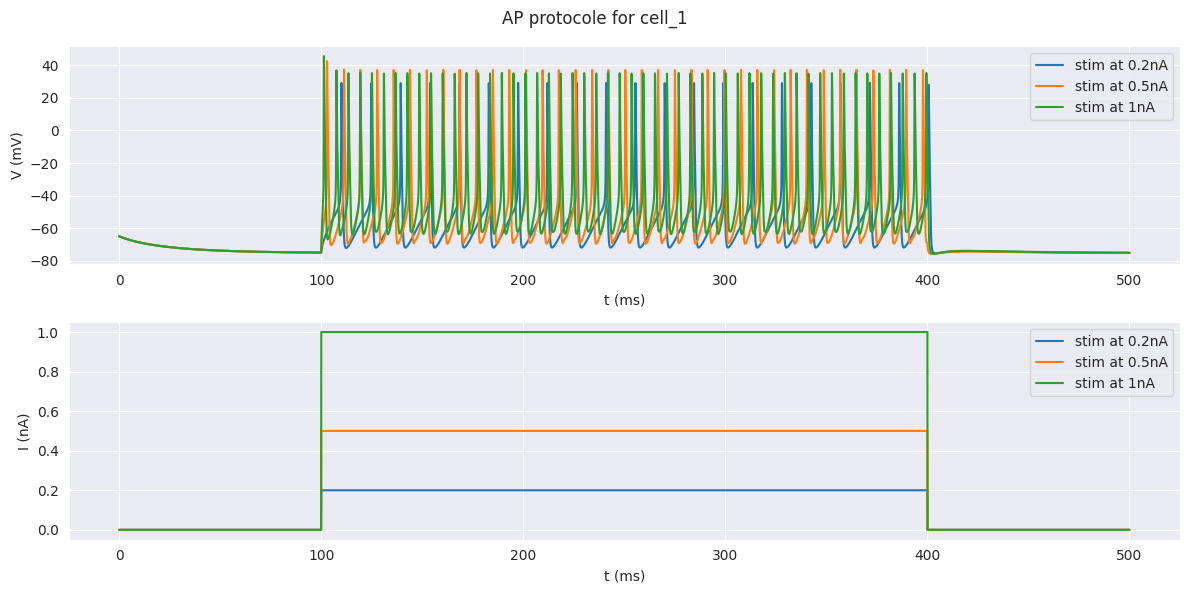

In [8]:
#passive protocol for cell 1
stim_ampl_pass = [- 0.05, - 0.01, 0.1]
passive_protocol(cell_1, 1, stim_ampl_pass)

#active protocol for cell 1
stim_ampl_acti = [0.2, 0.5, 1]
active_protocole(cell_1, 1,stim_ampl_acti)

### Second cell

In [9]:
cell_2 = NEURON('group8/Cell2_g6.asc')


15176 lines read

group8/Cell2_g6.asc problems


Main branch starting at line 8896 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


In [10]:
# As we didn't define all the cell properties, there are some that have defalut values
# We can check those values and check what other mechanisms are in the soma for instance.

cell_2.somatic[0].psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [3e-05], 'e': [-75.0], 'i': [0.0]},
  'NaTs2_t': {'gNaTs2_tbar': [0.25],
   'ina': [0.0],
   'gNaTs2_t': [0.0],
   'm': [0.0],
   'h': [0.0]},
  'SK_E2': {'gSK_E2bar': [0.01], 'ik': [0.0], 'gSK_E2': [0.0], 'z': [0.0]},
  'SKv3_1': {'gSKv3_1bar': [0.1], 'ik': [0.0], 'gSKv3_1': [0.0], 'm': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]},
  'ca': {'eca': [132.4579341637009],
   'cai': [5e-05],
   'cao': [2.0],
   'ica': [0.0],
   'dica_dv_': [0.0]}},
 'morphology': {'L': 26.112675393839726,
  'diam': [15.659698493178274],
  'pts3d': [(1.1156564950942993, -14.017075538635254, 0.0, 4.914276599884033),
   (1.1375269889831543, -12.711626052856445, 0.0, 9.000680923461914),
   (1.1593974828720093, -11.406174659729004, 0.0, 13.686775207519531),
   (1.1812678575515747, -10.10072422

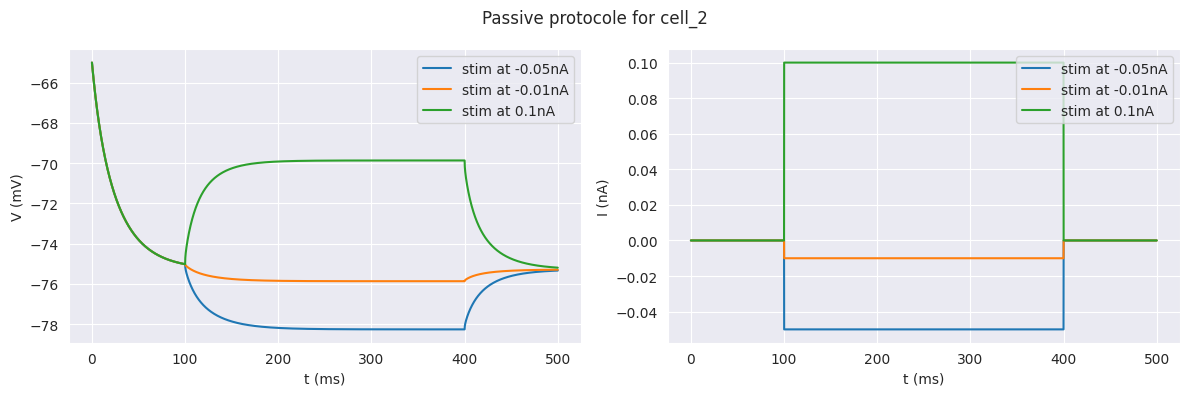

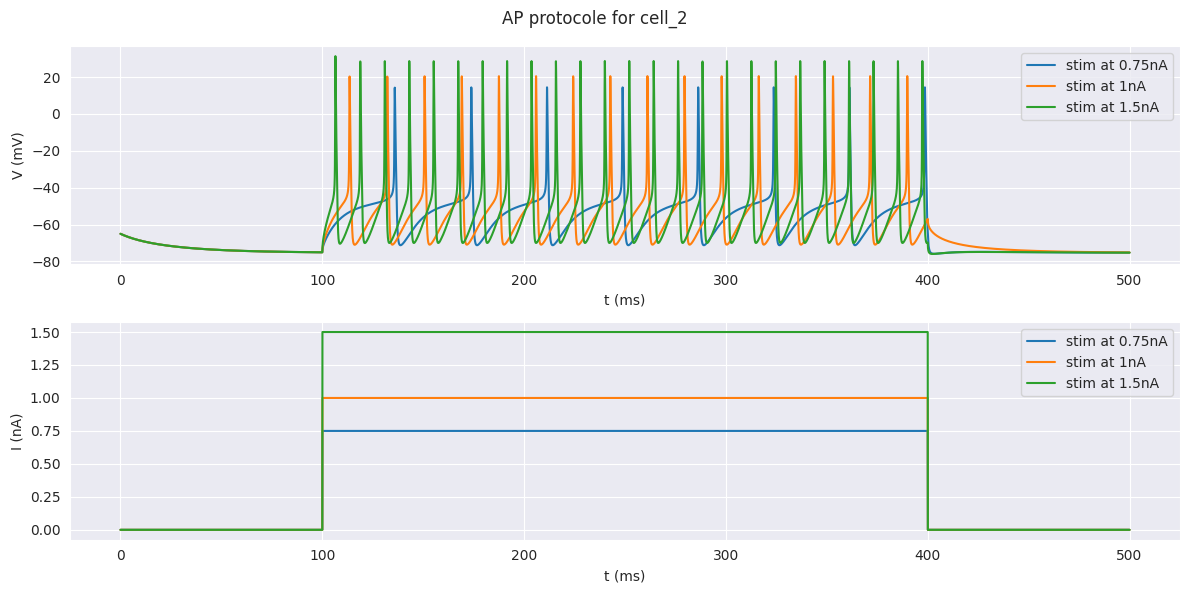

In [11]:
#passive protocol for cell 2
stim_ampl_pass = [- 0.05, - 0.01, 0.1]
passive_protocol(cell_2, 2, stim_ampl_pass)

#active protocol for cell 2
stim_ampl_acti = [0.75, 1, 1.5]
active_protocole(cell_2, 2,stim_ampl_acti)

# <font color= 'red'>Ex2:</font>. Analysing real single cell voltage traces from patch-clamp experiments

<font size='3'>Find the voltage base, firing frequency, spike count and after-hiperpolarization depth (AHP-depth) from the recordings that you can find in your folder group (.dat files). Extract the asked features from the one or several stimulation protocols that you think you can extract the features from.

<font size='3'>You can compute it as you wish, using eFEL, scipy.signal  or creating your own functions. <font color= 'red'>[2 pts]

#### Traces description

* The files are named with: stimuli type (e.g. "APWaveform", "FirePattern", "IV"). 
* Sweep (repetition) number: (e.g. "APWaveform_46-51"), of increasing/decreasing amplitudes.
* Note that we have pairs of recordings with the same trace number (e.g. "exp_APWaveform_ch7_51.dat" and "exp_APWaveform_ch6_51.dat"). One of them contains the current stimulus (in this case "*ch7*") and the other the voltage response (in this case "*ch6*").
    
    
_Hints_: 
1. If you are having trouble, consider this: we can extract voltage base from _____ traces, firing frequency from ______ and the AHP depth from some traces of __________. Note that only some voltage features such as voltage base, steady state voltage or minimum voltage can be extracted from __ traces, but not __ related features. 
2. Use section 3 of Efel documentation ([pdf](https://readthedocs.org/projects/efel/downloads/pdf/latest/)) to help you with the descriptions of the electrical features that you can find on the different traces.

# <font color= 'red'>Ex3:</font> Genetic Algorithm (Optimisation)

<font size='3'>Change the GA code in such a way that instead of the Spikecount feature, we search for a solution with AP amplitude of 96 for stim_amp = 0.5 nA and AP amplitdue of 85 for stim_amp = 0.05 nA.
    
<font size='3'>As you can see the optimisation algoithm explained in the tutorial is very simple and gives a lot of possible solutions. Explain and demonstrate how can you modify the GA optimisation to better contrain the returned solution. <font color= 'red'>[2 pts]
    